In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Creating Folder Structure

CustomModelTraining/

├── images

├── annotations/

├── models/

└── logs/

In [ ]:
from genericpath import exists
# Defining parent folder path
parent_folder = '/content/drive/MyDrive/model_training'

# Create child folder for data and result
child_folder = ['images','annotations','models','logs']

import os
# Create folder structure
for folder in child_folder:
  path = os.path.join(parent_folder,folder)
  os.makedirs(path,exist_ok=True)

print('Project folder structure created')

for folder in child_folder:
  print(f'{os.path.join(parent_folder,folder)}')

### Copy Images to the specific folder

In [ ]:
import shutil

source_images = '/content/drive/MyDrive/Images'
target_images = '/content/drive/MyDrive/model_training/images'

# Copy images only if target is empty
if len(os.listdir(target_images)) == 0:
    for file_name in os.listdir(source_images):
        full_file_name = os.path.join(source_images, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, target_images)

print(" Images copied to model_training/images/")

### Split images into train and validation set

In [ ]:
import shutil,random

base_dir = '/content/drive/MyDrive/model_training'
images_dir = os.path.join(base_dir, 'images')
train_dir = os.path.join(base_dir,'train','images')
val_dir = os.path.join(base_dir,'val','images')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

images_file = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
random.shuffle(images_file)

split_idx = int(0.8 * len(images_file))
train_files = images_file[:split_idx]
val_files = images_file[split_idx:]

# Move to train
for f in train_files:
    shutil.move(os.path.join(images_dir, f), os.path.join(train_dir, f))

# Move to val
for f in val_files:
    shutil.move(os.path.join(images_dir, f), os.path.join(val_dir, f))

print(f"Moved {len(train_files)} images to train/, {len(val_files)} to val/")


In [ ]:
for f in val_files:
  src = os.path.join(images_dir,f)
  dest = os.path.join(val_dir,f)
  print(f'moving {src} to {dest}')
  shutil.move(src,dest)

In [5]:
import os
base_dir = '/content/drive/MyDrive/model_training'
csv_path = os.path.join(base_dir,'annotations','labels.csv')

# Image+label folders
splits = ['train','val']
image_dirs = {split: os.path.join(base_dir,split,'images') for split in splits}
label_dirs = {split: os.path.join(base_dir,split,'labels') for split in splits}



In [7]:
df = pd.read_csv(csv_path,header=None)
df.columns = ['image_id', 'class_name', 'xmin', 'ymin', 'xmax', 'ymax']

In [ ]:
# Create label folders
for split in splits:
    os.makedirs(label_dirs[split],exist_ok=True)

In [8]:
# Map class names to ID
classes = sorted(df['class_name'].unique())
class_to_id = {cls:idx for idx,cls in enumerate(classes)}
print('class to index mapping:', class_to_id)

class to index mapping: {'articulated_truck': 0, 'bicycle': 1, 'bus': 2, 'car': 3, 'motorcycle': 4, 'motorized_vehicle': 5, 'non-motorized_vehicle': 6, 'pedestrian': 7, 'pickup_truck': 8, 'single_unit_truck': 9, 'work_van': 10}


In [9]:
# Function to convert bounding box to YOLO format ===
def convert_yolo(row, w, h):
    x_center = ((row['xmin'] + row['xmax']) / 2) / w
    y_center = ((row['ymin'] + row['ymax']) / 2) / h
    width = (row['xmax'] - row['xmin']) / w
    height = (row['ymax'] - row['ymin']) / h
    class_id = class_to_id[row['class_name']]
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

In [10]:
from PIL import Image
# Generate label files
for split in splits:
    print(f"Generating labels for {split} set")
    for img_file in os.listdir(image_dirs[split]):
        if not img_file.endswith('.jpg'):
            continue
        img_id = int(os.path.splitext(img_file)[0])  # 00000001.jpg → 1
        label_path = os.path.join(label_dirs[split], img_file.replace('.jpg', '.txt'))
        img_path = os.path.join(image_dirs[split], img_file)

        matched_rows = df[df['image_id'] == img_id]
        if matched_rows.empty:
            continue

        with Image.open(img_path) as img:
            w, h = img.size

        with open(label_path, 'w') as f:
            for _, row in matched_rows.iterrows():
                yolo_line = convert_yolo(row, w, h)
                f.write(yolo_line + '\n')

print("YOLO-format labels created in train/labels and val/labels")

In [12]:
import yaml
class_names = list(class_to_id.keys())

data_yaml = {
    'train': '/content/drive/MyDrive/model_training/train/images',
    'val': '/content/drive/MyDrive/model_training/val/images',
    'nc': len(class_names),
    'names': class_names
}

yaml_path = '/content/drive/MyDrive/model_training/data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"YOLO data.yaml created at: {yaml_path}")


YOLO data.yaml created at: /content/drive/MyDrive/model_training/data.yaml


In [13]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [15]:
## Training the YOLOv8 model
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model.train(
    data='/content/drive/MyDrive/model_training/data.yaml',
    epochs=25,
    imgsz=650,
    batch=16,
    project='/content/drive/MyDrive/model_training/models',
    name='yolo_model'
)

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/model_training/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=650, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_model10, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

train: Scanning /content/drive/MyDrive/model_training/train/labels... 4500 images, 2 backgrounds, 0 corrupt: 100%|██████████| 4500/4500 [12:21<00:00,  6.07it/s]


train: New cache created: /content/drive/MyDrive/model_training/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 3.2±5.0 ms, read: 0.1±0.0 MB/s, size: 24.2 KB)


val: Scanning /content/drive/MyDrive/model_training/val/labels.cache... 1126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1126/1126 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/model_training/models/yolo_model10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 672 train, 672 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/model_training/models/yolo_model10
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.39G      1.242      2.369       1.08         18        672: 100%|██████████| 282/282 [01:35<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:11<00:00,  3.07it/s]


                   all       1126       3542      0.533      0.294      0.279      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.54G      1.149      1.589      1.043         18        672: 100%|██████████| 282/282 [01:32<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.55it/s]


                   all       1126       3542      0.476      0.343      0.339      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.54G      1.135      1.396      1.036         31        672: 100%|██████████| 282/282 [01:31<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.32it/s]


                   all       1126       3542      0.503      0.443      0.373      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.55G      1.121      1.267      1.036         21        672: 100%|██████████| 282/282 [01:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.72it/s]


                   all       1126       3542      0.543      0.361      0.384      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.56G      1.083      1.147      1.025         23        672: 100%|██████████| 282/282 [01:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.36it/s]


                   all       1126       3542       0.55      0.437      0.441      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.56G      1.074      1.071      1.022         14        672: 100%|██████████| 282/282 [01:30<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.29it/s]


                   all       1126       3542      0.576      0.454       0.46      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.56G       1.06      1.038      1.012         36        672: 100%|██████████| 282/282 [01:31<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.68it/s]


                   all       1126       3542      0.431      0.523      0.486      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.56G       1.04     0.9849      1.005         16        672: 100%|██████████| 282/282 [01:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.34it/s]


                   all       1126       3542      0.487      0.515      0.509       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.56G      1.038     0.9612      1.003         10        672: 100%|██████████| 282/282 [01:31<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.38it/s]


                   all       1126       3542       0.64      0.483      0.522      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.56G       1.02     0.9367     0.9987         15        672: 100%|██████████| 282/282 [01:33<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.47it/s]


                   all       1126       3542      0.504       0.55      0.545      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.57G       1.01     0.9079     0.9932         23        672: 100%|██████████| 282/282 [01:31<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.28it/s]

                   all       1126       3542      0.631      0.547      0.566      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       2.6G      1.005     0.8877       0.99         18        672: 100%|██████████| 282/282 [01:33<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.56it/s]


                   all       1126       3542      0.625      0.541      0.561      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       2.6G     0.9928     0.8618     0.9841         24        672: 100%|██████████| 282/282 [01:31<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.93it/s]


                   all       1126       3542      0.592      0.571       0.58      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       2.6G     0.9824      0.844     0.9832         18        672: 100%|██████████| 282/282 [01:35<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.34it/s]

                   all       1126       3542      0.695      0.566      0.594      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       2.6G      0.975     0.8195     0.9788         25        672: 100%|██████████| 282/282 [01:31<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.28it/s]

                   all       1126       3542      0.563      0.582      0.606      0.431


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       2.6G     0.9504     0.7617      0.958          7        672: 100%|██████████| 282/282 [01:29<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.72it/s]

                   all       1126       3542      0.596      0.549      0.584      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       2.6G     0.9413     0.7293     0.9561         17        672: 100%|██████████| 282/282 [01:27<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.58it/s]


                   all       1126       3542      0.623      0.533        0.6      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       2.6G      0.931     0.7177     0.9509         26        672: 100%|██████████| 282/282 [01:27<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.55it/s]

                   all       1126       3542      0.619      0.548      0.608      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       2.6G     0.9213      0.693     0.9472          9        672: 100%|██████████| 282/282 [01:27<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.67it/s]

                   all       1126       3542      0.567      0.607      0.601      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       2.6G     0.9131     0.6734     0.9431         12        672: 100%|██████████| 282/282 [01:27<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.59it/s]

                   all       1126       3542      0.625      0.575      0.617      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       2.6G     0.9086     0.6641     0.9422         21        672: 100%|██████████| 282/282 [01:27<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.77it/s]

                   all       1126       3542      0.599      0.625      0.633      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       2.6G     0.8993     0.6412     0.9363         14        672: 100%|██████████| 282/282 [01:27<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.70it/s]

                   all       1126       3542      0.583      0.628       0.63      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       2.6G     0.8895      0.629     0.9389         14        672: 100%|██████████| 282/282 [01:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.84it/s]

                   all       1126       3542      0.598      0.627       0.64      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       2.6G     0.8811     0.6141     0.9334          7        672: 100%|██████████| 282/282 [01:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


                   all       1126       3542      0.629      0.628      0.644      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       2.6G     0.8731     0.5958     0.9266         13        672: 100%|██████████| 282/282 [01:28<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.92it/s]

                   all       1126       3542      0.627      0.613      0.644      0.481



25 epochs completed in 0.705 hours.
Optimizer stripped from /content/drive/MyDrive/model_training/models/yolo_model10/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/model_training/models/yolo_model10/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/model_training/models/yolo_model10/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:11<00:00,  3.00it/s]


                   all       1126       3542      0.627      0.614      0.644      0.481
     articulated_truck         84         94      0.668       0.77      0.745      0.557
               bicycle         20         22      0.659      0.773      0.798       0.59
                   bus         84         92      0.874      0.913      0.947      0.847
                   car        946       2399      0.859      0.872      0.918      0.679
            motorcycle         17         20       0.83      0.735      0.808       0.54
     motorized_vehicle        199        247      0.458      0.336      0.356      0.198
 non-motorized_vehicle         31         31      0.176     0.0645     0.0951     0.0618
            pedestrian         34         56      0.557      0.446      0.483      0.264
          pickup_truck        312        429      0.761      0.821      0.865      0.719
     single_unit_truck         51         53      0.422      0.434      0.445      0.318
              work_va

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8ad82ec950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.


image 1/1 /content/drive/MyDrive/model_training/val/images/00000004.jpg: 448x672 1 bus, 39.0ms
Speed: 2.4ms preprocess, 39.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 672)
Results saved to /content/drive/MyDrive/model_training/models/yolo_model102


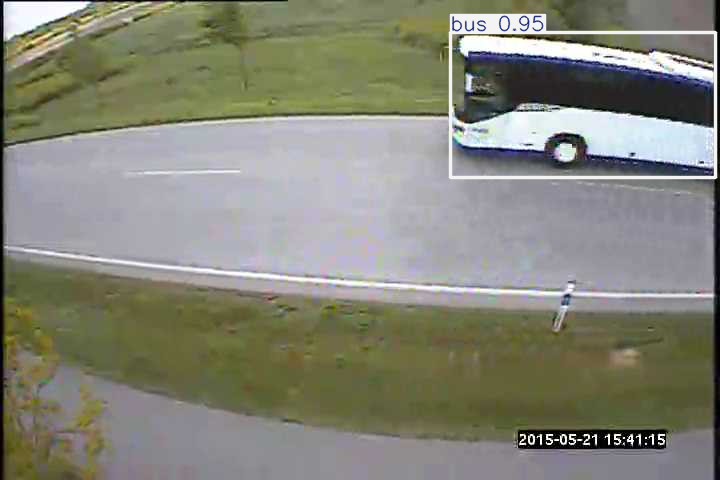

In [16]:
# Run inference on a validation image
result = model.predict(source='/content/drive/MyDrive/model_training/val/images/00000004.jpg', save=True)

# Optionally display in notebook
result[0].show()


image 1/1 /content/drive/MyDrive/model_training/val/images/00000183.jpg: 448x672 7 cars, 1 motorized_vehicle, 2 pickup_trucks, 9.1ms
Speed: 4.5ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 672)
Results saved to /content/drive/MyDrive/model_training/models/yolo_model103


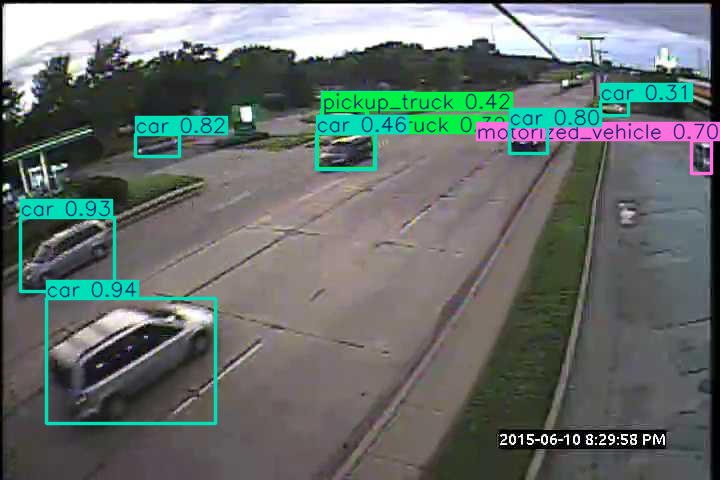

In [17]:
result = model.predict(source='/content/drive/MyDrive/model_training/val/images/00000183.jpg', save=True)
result[0].show()


image 1/1 /content/drive/MyDrive/model_training/val/images/00000658.jpg: 448x672 1 articulated_truck, 2 cars, 2 pickup_trucks, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 672)
Results saved to /content/drive/MyDrive/model_training/models/yolo_model104


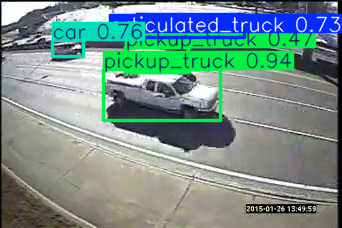

In [18]:
result = model.predict(source='/content/drive/MyDrive/model_training/val/images/00000658.jpg', save=True)
result[0].show()


image 1/1 /content/drive/MyDrive/model_training/train/images/00000561.jpg: 448x672 1 bus, 19 cars, 1 motorized_vehicle, 2 pedestrians, 11.5ms
Speed: 3.5ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 672)
Results saved to /content/drive/MyDrive/model_training/models/yolo_model105


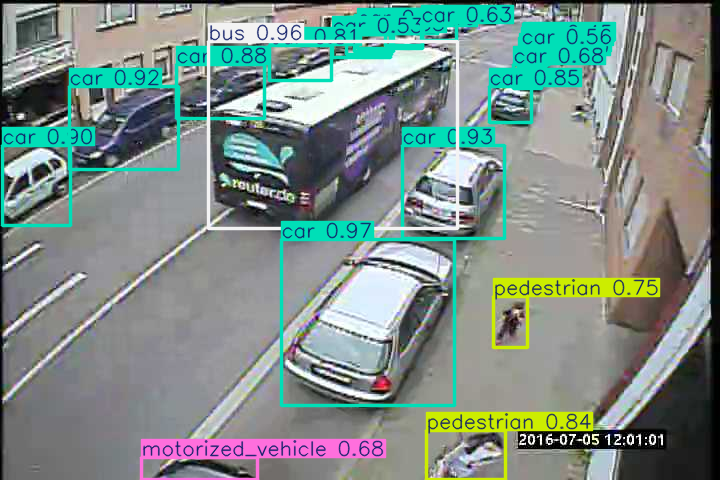

In [19]:
result = model.predict(source='/content/drive/MyDrive/model_training/train/images/00000561.jpg', save=True)
result[0].show()

### Validation

In [20]:
metrics = model.val()

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 21.5±11.1 MB/s, size: 26.4 KB)


val: Scanning /content/drive/MyDrive/model_training/val/labels.cache... 1126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1126/1126 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:16<00:00,  4.25it/s]


                   all       1126       3542      0.625      0.614      0.645      0.482
     articulated_truck         84         94      0.668      0.771      0.747      0.558
               bicycle         20         22       0.66      0.773      0.799      0.585
                   bus         84         92      0.874      0.913      0.947      0.848
                   car        946       2399      0.858      0.874      0.919       0.68
            motorcycle         17         20       0.83      0.735      0.808      0.547
     motorized_vehicle        199        247      0.457      0.336      0.356      0.197
 non-motorized_vehicle         31         31      0.175     0.0645     0.0956     0.0622
            pedestrian         34         56      0.545      0.446      0.482      0.264
          pickup_truck        312        429      0.761      0.821      0.865      0.719
     single_unit_truck         51         53      0.417      0.434      0.447      0.323
              work_va

In [21]:
final_1 = pd.DataFrame(metrics.names.items(), columns=['Class_ID','Class_name'])
final_2 = pd.DataFrame(metrics.maps, columns=['Accuracy'])
final_df = pd.concat([final_1,final_2], axis=1)

In [22]:
final_df

,Class_ID,Class_name,Accuracy
0,0,articulated_truck,0.557539
1,1,bicycle,0.585226
2,2,bus,0.847728
3,3,car,0.680027
4,4,motorcycle,0.546991
5,5,motorized_vehicle,0.197462
6,6,non-motorized_vehicle,0.062238
7,7,pedestrian,0.264059
8,8,pickup_truck,0.718753
9,9,single_unit_truck,0.322745
